In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 110

# --- Load detailed eval outputs ---
with open("C:\\MSK_Triage_Chatbot\\MSK_Chat\\eval_results_topicaware.json", "r", encoding="utf-8") as f:
    base_raw = json.load(f)

with open("C:\\MSK_Triage_Chatbot\\MSK_Chat\\eval_results_topicaware_reranked.json", "r", encoding="utf-8") as f:
    rer_raw = json.load(f)

# --- Load summary CSVs (last row = most recent run) ---
hist_base = pd.read_csv("C:\\MSK_Triage_Chatbot\\MSK_Chat\\Evaluation\\eval_history.csv").iloc[-1]
hist_rer  = pd.read_csv("C:\\MSK_Triage_Chatbot\\MSK_Chat\\Evaluation\\eval_history_reranked.csv").iloc[-1]

print(f"Loaded {len(base_raw)} queries (baseline) and {len(rer_raw)} (reranked).")


def first_hit_rank(ids, gt_ids):
    """1-based rank of first correct hit; None if never."""
    gt = set(gt_ids or [])
    for i, cid in enumerate(ids, start=1):
        if cid in gt:
            return i
    return None


# --- Build per-query comparison DataFrame ---
rows = []
for b, r in zip(base_raw, rer_raw):
    assert b["query"] == r["query"]
    gt = b.get("gt_chunk_ids") or []

    rb = first_hit_rank(b["returned_ids_base"], gt)     # baseline retrieval
    rr = first_hit_rank(r["returned_ids"], gt)          # final reranked list

    rows.append({
        "query": b["query"],
        "topic": b.get("topic", "Unknown"),
        "rb": rb,
        "rr": rr,
        "map5_base": b["MAP"]["5"],
        "map5_rer":  r["MAP"]["5"],
    })

df = pd.DataFrame(rows)
print(df.head())


Loaded 50 queries (baseline) and 50 (reranked).
                                               query topic  rb    rr  \
0            What is Atlantoaxial Instability (AAI)?   AAI   2   1.0   
1  What mechanisms cause Atlantoaxial Instability...   AAI   1   NaN   
2  What symptoms are characteristic of Atlantoaxi...   AAI   2   4.0   
3  How is Atlantoaxial Instability clinically ass...   AAI   5  14.0   
4          What is Craniocervical Instability (CCI)?   CCI   1   1.0   

   map5_base  map5_rer  
0   0.166667  0.500000  
1   0.500000  0.000000  
2   0.125000  0.062500  
3   0.050000  0.000000  
4   0.333333  0.333333  


Hit@5  – base/rer: 0.94 0.38
MAP@5  – base/rer: 0.40739999999999993 0.11075000000000002
MRR    – base/rer: 0.7616190476190476 0.280861390334139


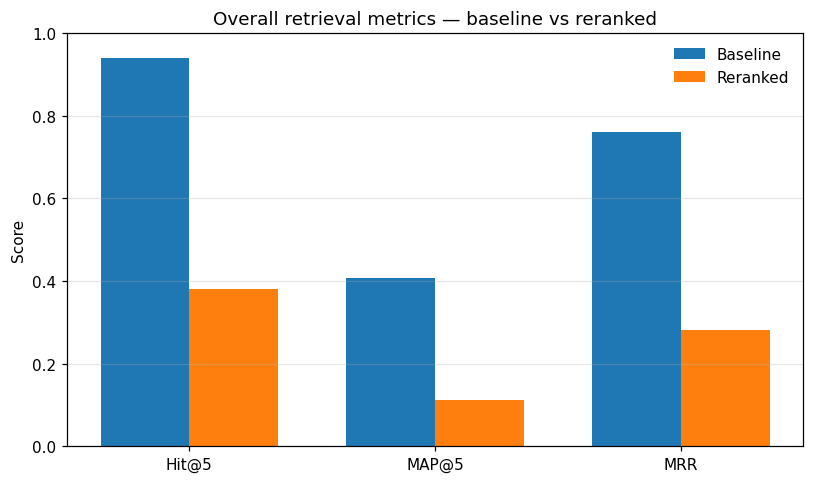

In [13]:
# --- Compute overall retrieval metrics from df -------------------------

def hit_at_k(ranks, k: int) -> float:
    """Fraction of queries with first relevant hit at rank ≤ k."""
    arr = []
    for r in ranks:
        if r is None or (isinstance(r, float) and np.isnan(r)):
            arr.append(np.inf)
        else:
            arr.append(float(r))
    arr = np.array(arr)
    return float((arr <= k).mean())


def mrr(ranks) -> float:
    """Mean Reciprocal Rank using first relevant hit (None → 0)."""
    vals = []
    for r in ranks:
        if r is None or (isinstance(r, float) and np.isnan(r)):
            vals.append(0.0)
        else:
            vals.append(1.0 / float(r))
    return float(np.mean(vals))


# Overall metrics (chunk-level)
hit5_base = hit_at_k(df["rb"], k=5)
hit5_rer  = hit_at_k(df["rr"], k=5)

map5_base = float(df["map5_base"].mean())
map5_rer  = float(df["map5_rer"].mean())

mrr_base = mrr(df["rb"])
mrr_rer  = mrr(df["rr"])

print("Hit@5  – base/rer:", hit5_base, hit5_rer)
print("MAP@5  – base/rer:", map5_base, map5_rer)
print("MRR    – base/rer:", mrr_base, mrr_rer)

# --- Slide-ready grouped bar chart ------------------------------------

metrics   = ["Hit@5", "MAP@5", "MRR"]
baseline  = [hit5_base, map5_base, mrr_base]
reranked  = [hit5_rer,  map5_rer,  mrr_rer]

plt.figure(figsize=(7.5, 4.5))
x = np.arange(len(metrics))
width = 0.36

plt.bar(x - width/2, baseline, width, label="Baseline")
plt.bar(x + width/2, reranked, width, label="Reranked")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0.0, 1.0)
plt.title("Overall retrieval metrics — baseline vs reranked")
plt.grid(axis="y", alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()

# For paper / slides, optionally save instead of or in addition to show():
# plt.savefig(r"C:\MSK_Triage_Chatbot\figures\overall_retrieval_baseline_vs_reranked.png",
#             dpi=300, bbox_inches="tight")

plt.show()


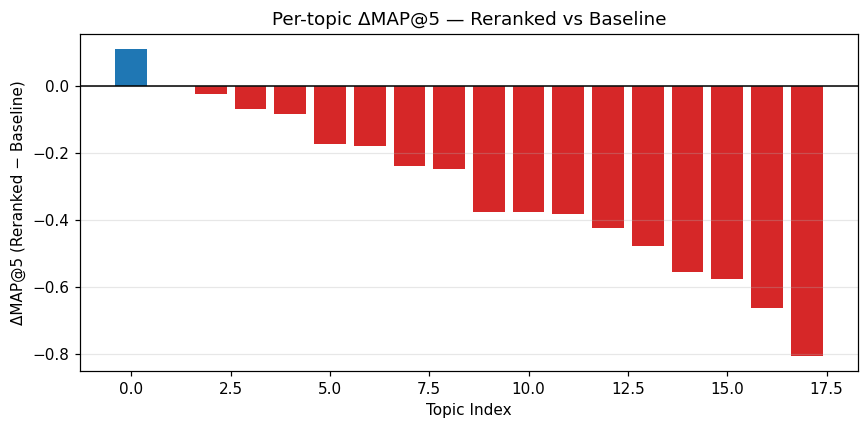

In [15]:
# --- Paper-ready ΔMAP@5 plot (baseline vs reranked) ----------------------------

# Compute delta for each topic
topic_map = (
    df.groupby("topic")[["map5_base","map5_rer"]]
      .mean()
      .assign(delta=lambda d: d["map5_rer"] - d["map5_base"])
      .sort_values("delta", ascending=False)
)

# Plot (no topic labels, just index numbers)
plt.figure(figsize=(8,4))
x = np.arange(len(topic_map))

plt.bar(x, topic_map["delta"], color=["#1f77b4" if v >= 0 else "#d62728" for v in topic_map["delta"]])

plt.axhline(0, color="black", linewidth=1)
plt.ylabel("ΔMAP@5 (Reranked − Baseline)")
plt.xlabel("Topic Index")
plt.title("Per-topic ΔMAP@5 — Reranked vs Baseline")

# Grid for readability
plt.grid(axis="y", alpha=0.3)

# Tight layout for publication
plt.tight_layout()
plt.show()


#Corpus/Chunks Stats


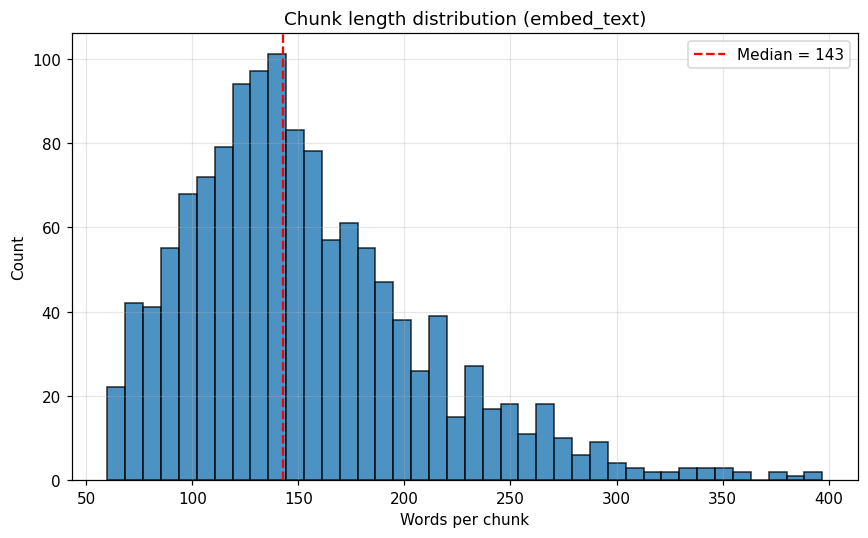

Mean words: 153.5
10th–90th percentile: [ 90.  229.8]


In [2]:
from pathlib import Path

df_chunks = pd.read_parquet("C:\\MSK_Triage_Chatbot\\MSK_Chat\\MSKArticlesINDEX\\chunks.parquet")

# Use embed_text as your retrieval text
texts = df_chunks["embed_text"].astype(str)
word_counts = texts.str.split().apply(len)

plt.figure(figsize=(8,5))
plt.hist(word_counts, bins=40, edgecolor="black", alpha=0.8)
plt.xlabel("Words per chunk")
plt.ylabel("Count")
plt.title("Chunk length distribution (embed_text)")
plt.axvline(word_counts.median(), color="red", linestyle="--", label=f"Median = {word_counts.median():.0f}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Mean words: {word_counts.mean():.1f}")
print(f"10th–90th percentile: {np.percentile(word_counts, [10,90])}")


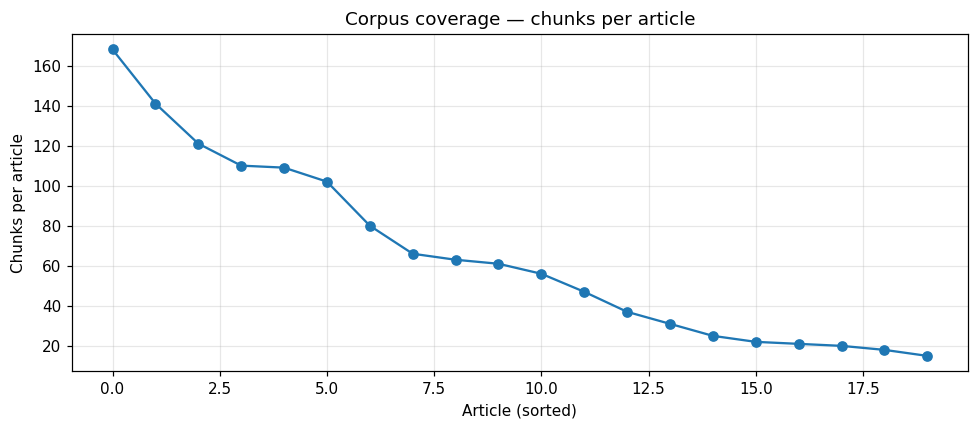

Median chunks/article: 58.5
Top 5 longest articles:
 source_relpath
mskneurology.com/atlas-joint-instability-causes-consequences-solutions/index.html    168
mskneurology.com/multifactorial-causes-solutions-chronic-neck-pain/index.html        141
mskneurology.com/permanently-resolve-scapular-dyskinesis/index.html                  121
mskneurology.com/association-tinnitus-neck-tmj/index.html                            110
mskneurology.com/how-truly-treat-thoracic-outlet-syndrome/index.html                 109
Name: count, dtype: int64


In [3]:
chunks_per_article = df_chunks["source_relpath"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(9,4))
plt.plot(chunks_per_article.values, marker="o")
plt.xlabel("Article (sorted)")
plt.ylabel("Chunks per article")
plt.title("Corpus coverage — chunks per article")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Median chunks/article:", chunks_per_article.median())
print("Top 5 longest articles:\n", chunks_per_article.head())


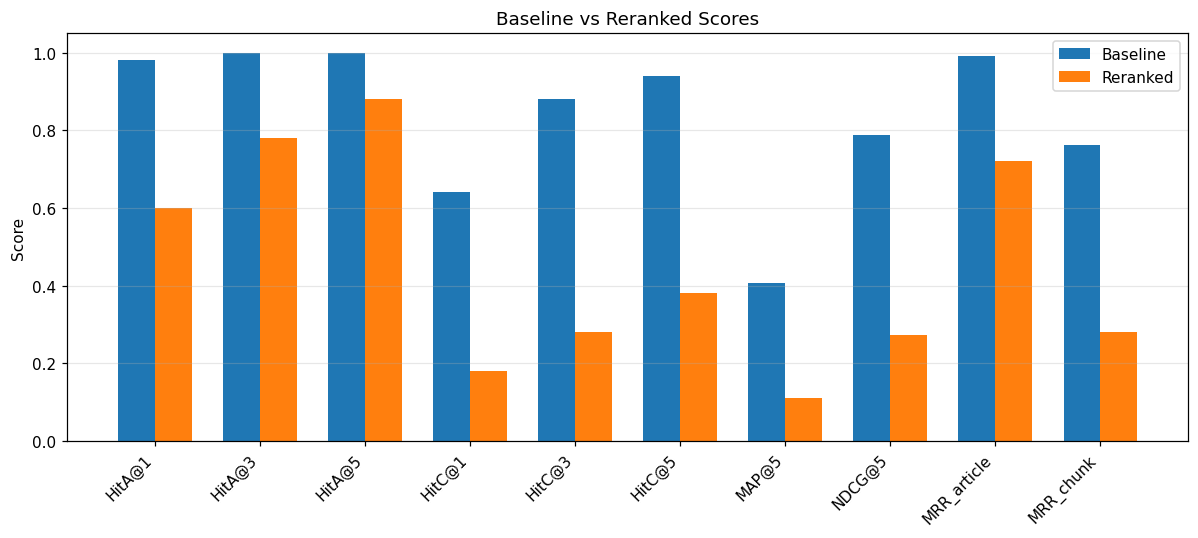

In [4]:
metrics = ["HitA@1","HitA@3","HitA@5",
           "HitC@1","HitC@3","HitC@5",
           "MAP@5","NDCG@5",
           "MRR_article","MRR_chunk"]

base_vals = [hist_base[m] for m in metrics]
rer_vals  = [hist_rer[m]  for m in metrics]

x = np.arange(len(metrics))
w = 0.35

plt.figure(figsize=(11,5))
plt.bar(x - w/2, base_vals, w, label="Baseline")
plt.bar(x + w/2, rer_vals,  w, label="Reranked")

plt.xticks(x, metrics, rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Baseline vs Reranked Scores")
plt.ylim(0, 1.05)
plt.grid(alpha=0.3, axis="y")
plt.legend()
plt.tight_layout()
plt.show()


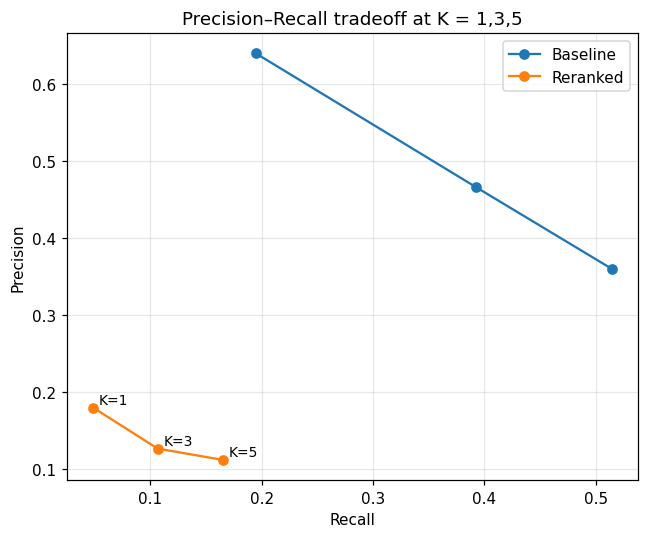

In [5]:
Ks = [1, 3, 5]

base_prec = [hist_base[f"Precision@{k}"] for k in Ks]
base_rec  = [hist_base[f"Recall@{k}"] for k in Ks]
rer_prec  = [hist_rer[f"Precision@{k}"] for k in Ks]
rer_rec   = [hist_rer[f"Recall@{k}"] for k in Ks]

plt.figure(figsize=(6,5))
plt.plot(base_rec, base_prec, "-o", label="Baseline")
plt.plot(rer_rec, rer_prec, "-o", label="Reranked")
for k, rp, rr in zip(Ks, rer_prec, rer_rec):
    plt.text(rr+0.005, rp+0.005, f"K={k}", fontsize=9)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall tradeoff at K = 1,3,5")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



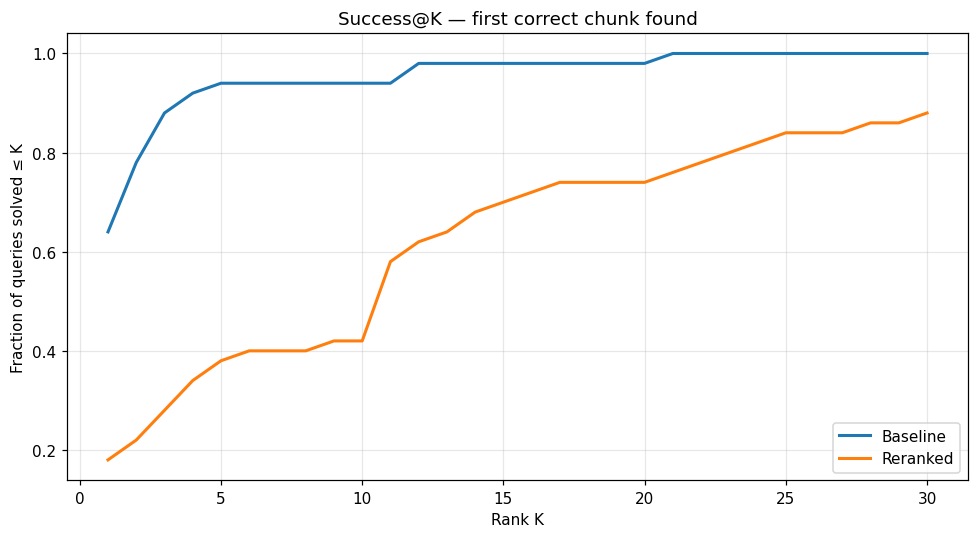

In [6]:
def success_at_k(ranks, Kmax=30):
    ks = np.arange(1, Kmax+1)
    vals = [(ranks.notna() & (ranks <= k)).mean() for k in ks]
    return ks, vals

ks, sb = success_at_k(df["rb"])
_,  sr = success_at_k(df["rr"])

plt.figure(figsize=(9,5))
plt.plot(ks, sb, label="Baseline", linewidth=2)
plt.plot(ks, sr, label="Reranked", linewidth=2)
plt.xlabel("Rank K")
plt.ylabel("Fraction of queries solved ≤ K")
plt.title("Success@K — first correct chunk found")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


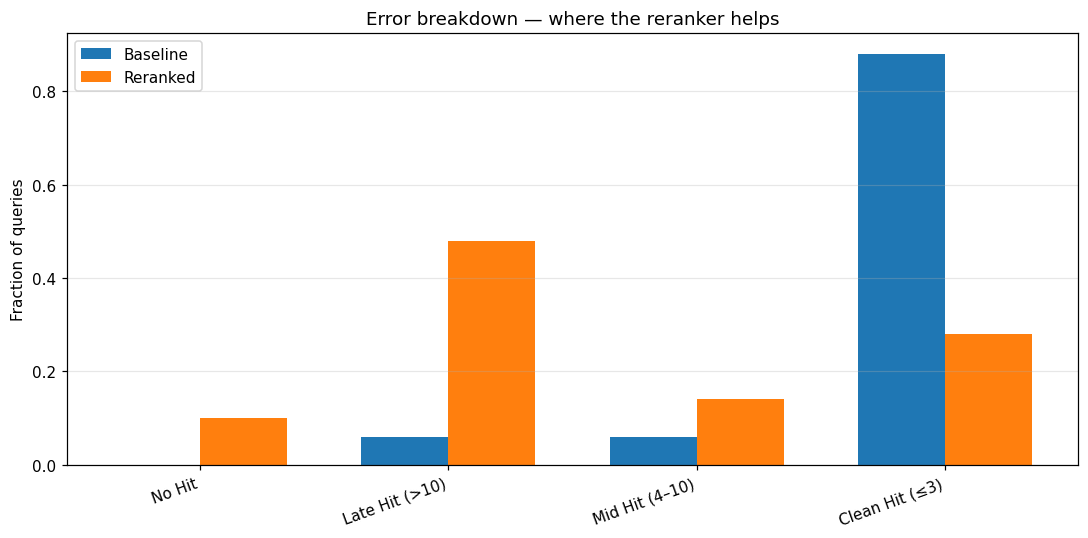

(base_label
 No Hit            0.00
 Late Hit (>10)    0.06
 Mid Hit (4–10)    0.06
 Clean Hit (≤3)    0.88
 Name: proportion, dtype: float64,
 rer_label
 No Hit            0.10
 Late Hit (>10)    0.48
 Mid Hit (4–10)    0.14
 Clean Hit (≤3)    0.28
 Name: proportion, dtype: float64)

In [7]:
def classify(rank):
    if pd.isna(rank):
        return "No Hit"
    if rank <= 3:
        return "Clean Hit (≤3)"
    if rank <= 10:
        return "Mid Hit (4–10)"
    return "Late Hit (>10)"

df["base_label"] = df["rb"].apply(classify)
df["rer_label"]  = df["rr"].apply(classify)

labels = ["No Hit","Late Hit (>10)","Mid Hit (4–10)","Clean Hit (≤3)"]

base_counts = df["base_label"].value_counts(normalize=True).reindex(labels).fillna(0)
rer_counts  = df["rer_label"].value_counts(normalize=True).reindex(labels).fillna(0)

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - w/2, base_counts, w, label="Baseline")
plt.bar(x + w/2, rer_counts,  w, label="Reranked")

plt.xticks(x, labels, rotation=20, ha="right")
plt.ylabel("Fraction of queries")
plt.title("Error breakdown — where the reranker helps")
plt.grid(alpha=0.3, axis="y")
plt.legend()
plt.tight_layout()
plt.show()

base_counts, rer_counts


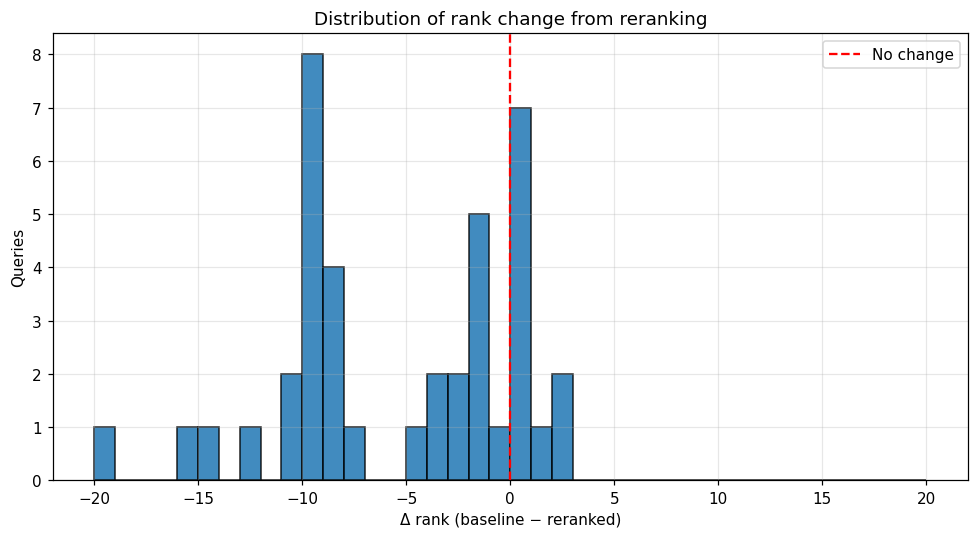

Improved (Δ>0): 0.06666666666666667
Worsened (Δ<0): 0.7777777777777778


In [8]:
df_delta = df.copy()
df_delta = df_delta.dropna(subset=["rb", "rr"])

df_delta["delta_rank"] = df_delta["rb"] - df_delta["rr"]  # >0 = improved, <0 = worse

plt.figure(figsize=(9,5))
plt.hist(df_delta["delta_rank"], bins=range(-20,21), edgecolor="black", alpha=0.85)
plt.axvline(0, color="red", linestyle="--", label="No change")
plt.xlabel("Δ rank (baseline − reranked)")
plt.ylabel("Queries")
plt.title("Distribution of rank change from reranking")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("Improved (Δ>0):", (df_delta["delta_rank"] > 0).mean())
print("Worsened (Δ<0):", (df_delta["delta_rank"] < 0).mean())


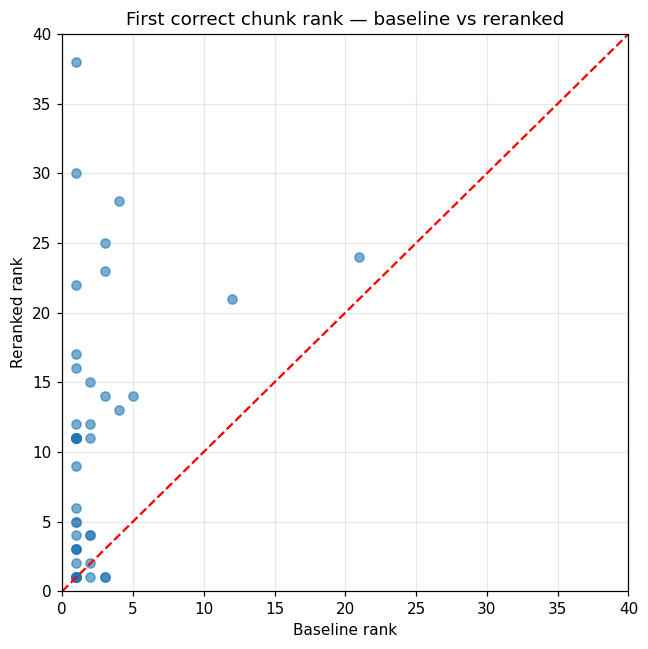

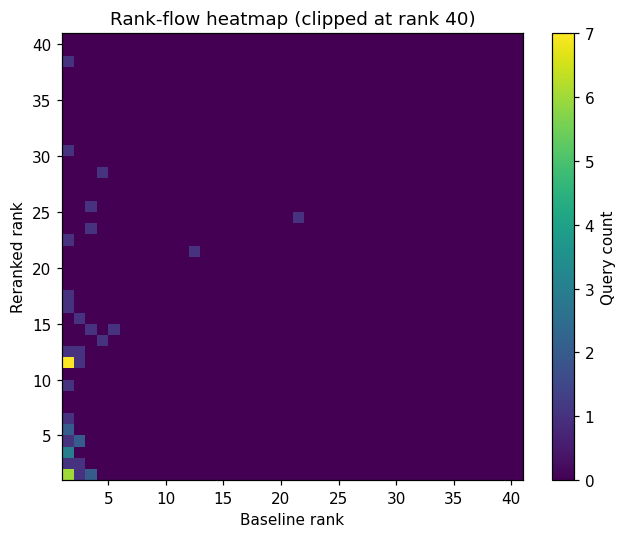

In [9]:
# Basic scatter
plt.figure(figsize=(6,6))
plt.scatter(df["rb"], df["rr"], alpha=0.6)
plt.xlabel("Baseline rank")
plt.ylabel("Reranked rank")
plt.title("First correct chunk rank — baseline vs reranked")
plt.grid(alpha=0.3)
plt.axline((0,0),(1,1),color="red",linestyle="--")
plt.xlim(0,40)
plt.ylim(0,40)
plt.tight_layout()
plt.show()

# 2D histogram (heatmap)
plt.figure(figsize=(6,5))
plt.hist2d(df["rb"].fillna(50), df["rr"].fillna(50),
           bins=[np.arange(1,42), np.arange(1,42)])
plt.colorbar(label="Query count")
plt.xlabel("Baseline rank")
plt.ylabel("Reranked rank")
plt.title("Rank-flow heatmap (clipped at rank 40)")
plt.tight_layout()
plt.show()


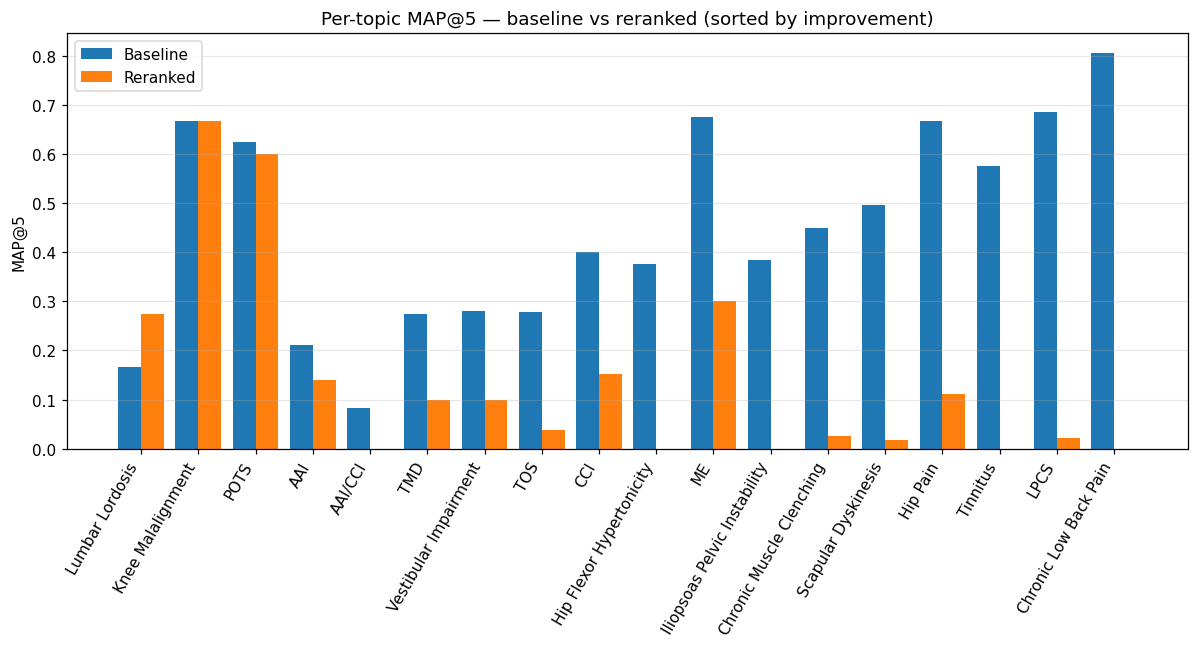

,map5_base,map5_rer,delta
topic,,,
Lumbar Lordosis,0.166667,0.275000,0.108333
Knee Malalignment,0.666667,0.666667,0.000000
POTS,0.625000,0.600000,-0.025000
AAI,0.210417,0.140625,-0.069792
AAI/CCI,0.083333,0.000000,-0.083333
TMD,0.275000,0.100000,-0.175000
Vestibular Impairment,0.279861,0.100000,-0.179861
TOS,0.277778,0.038889,-0.238889
CCI,0.400000,0.152778,-0.247222


In [10]:
topic_map = (
    df.groupby("topic")[["map5_base","map5_rer"]]
      .mean()
      .assign(delta=lambda d: d["map5_rer"] - d["map5_base"])
      .sort_values("delta", ascending=False)
)

plt.figure(figsize=(11,6))
x = np.arange(len(topic_map))

plt.bar(x - 0.2, topic_map["map5_base"], width=0.4, label="Baseline")
plt.bar(x + 0.2, topic_map["map5_rer"],  width=0.4, label="Reranked")

plt.xticks(x, topic_map.index, rotation=60, ha="right")
plt.ylabel("MAP@5")
plt.title("Per-topic MAP@5 — baseline vs reranked (sorted by improvement)")
plt.grid(alpha=0.3, axis="y")
plt.legend()
plt.tight_layout()
plt.show()

topic_map



In [11]:
rescued = df[
    ((df["rb"].isna()) | (df["rb"] > 10)) &   # baseline fail/late
    (df["rr"].notna()) & (df["rr"] <= 5)      # reranked success
].copy()

rescued = rescued.sort_values("rr").head(10)

rescued[["topic","rb","rr","query"]]


,topic,rb,rr,query


In [12]:
import sys, time
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT / "VectorDB"))

from qaEngine import run_qa, QAConfig

questions = [item["query"] for item in base_raw]

cfg = QAConfig(
    top_k=6,
    per_source_max=2,
    budget_tokens=1024,
    neighbor_headroom=120,
    use_reranker=True,
    generate_answer=False,   # correct
)

stats = []

for q in questions:
    t0 = time.time()             # ← measure full pipeline start
    out = run_qa(q, config=cfg)
    t1 = time.time()             # ← end of full pipeline

    pipeline_time = t1 - t0      # ← true non-LLM latency

    ctx = out.get("contexts", [])

    stats.append({
        "query": q,
        "retrieval_time": out.get("retrieval_time", np.nan),
        "pipeline_time": pipeline_time,           # ← MAIN NEW METRIC
        "context_tokens": out.get("context_tokens", np.nan),
        "question_tokens": out.get("question_tokens", np.nan),
        "n_chunks": len(ctx),
    })

df_sys = pd.DataFrame(stats)
df_sys.describe()


c:\Users\Draco\miniconda3\envs\msk_chat\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[RERANKER] model=gpt-4.1-mini | top_n=10 | use=True


UnboundLocalError: cannot access local variable 'first_token_latency' where it is not associated with a value

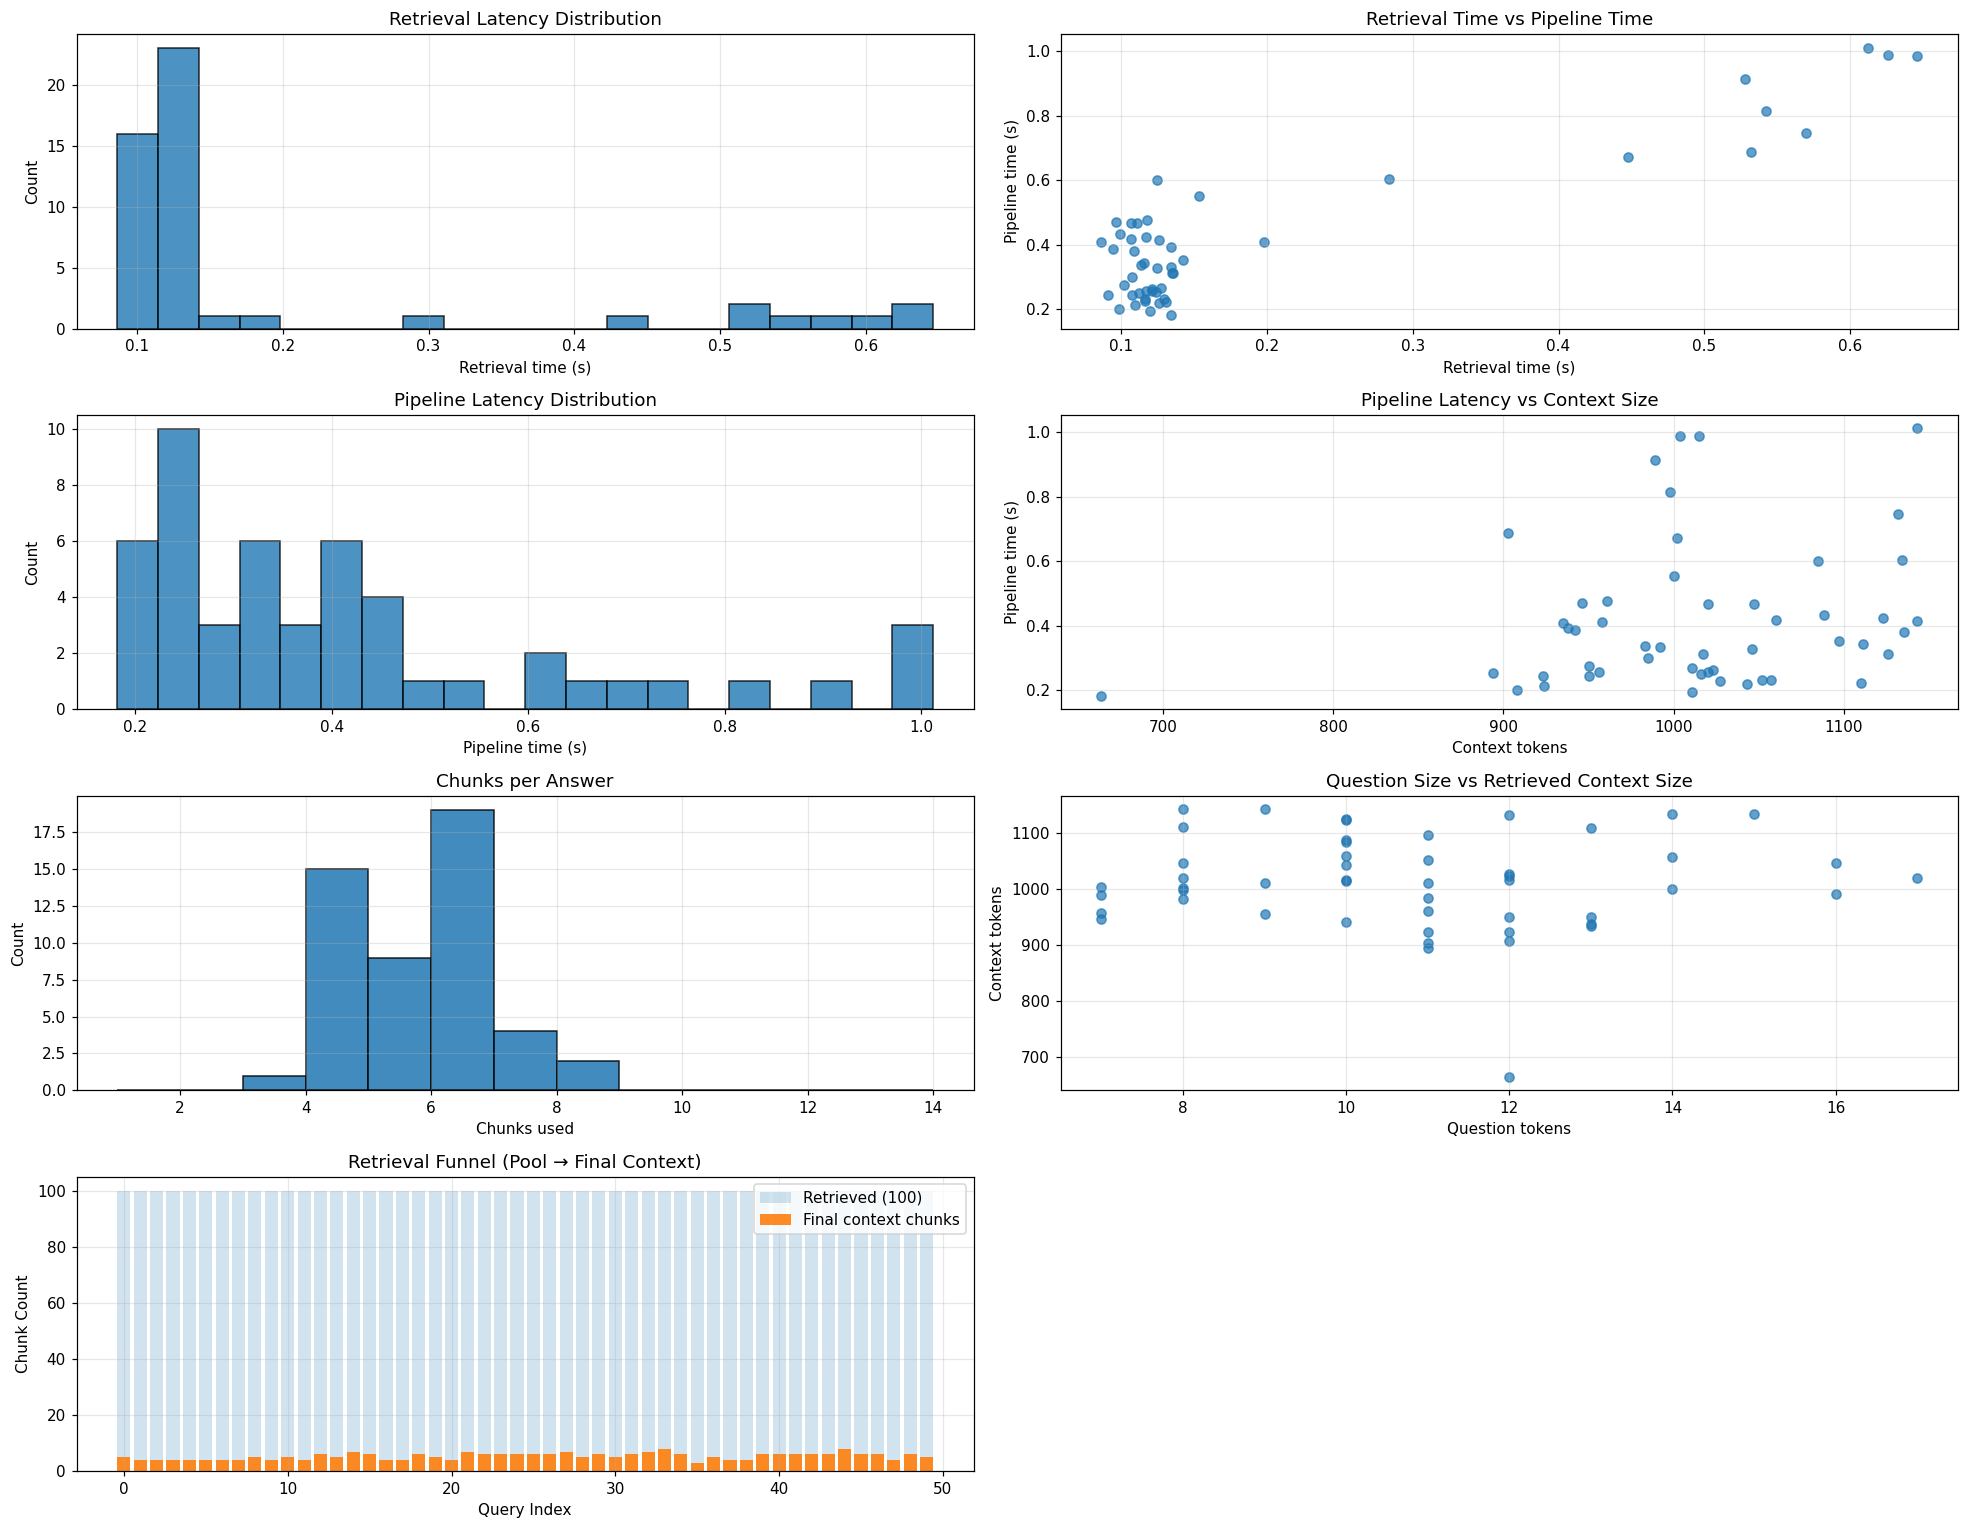

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = axes.flatten()

# -----------------------------------------------------------
# 1 — Retrieval latency histogram (Option C)
axes[0].hist(df_sys["retrieval_time"], bins=20, edgecolor="black", alpha=0.8)
axes[0].set_title("Retrieval Latency Distribution")
axes[0].set_xlabel("Retrieval time (s)")
axes[0].set_ylabel("Count")
axes[0].grid(alpha=0.3)

# -----------------------------------------------------------
# 2 — Retrieval time vs pipeline time (Option A)
axes[1].scatter(df_sys["retrieval_time"], df_sys["pipeline_time"], alpha=0.7)
axes[1].set_title("Retrieval Time vs Pipeline Time")
axes[1].set_xlabel("Retrieval time (s)")
axes[1].set_ylabel("Pipeline time (s)")
axes[1].grid(alpha=0.3)

# -----------------------------------------------------------
# 3 — Pipeline time distribution
axes[2].hist(df_sys["pipeline_time"], bins=20, edgecolor="black", alpha=0.8)
axes[2].set_title("Pipeline Latency Distribution")
axes[2].set_xlabel("Pipeline time (s)")
axes[2].set_ylabel("Count")
axes[2].grid(alpha=0.3)

# -----------------------------------------------------------
# 4 — Latency vs context size
axes[3].scatter(df_sys["context_tokens"], df_sys["pipeline_time"], alpha=0.7)
axes[3].set_title("Pipeline Latency vs Context Size")
axes[3].set_xlabel("Context tokens")
axes[3].set_ylabel("Pipeline time (s)")
axes[3].grid(alpha=0.3)

# -----------------------------------------------------------
# 5 — Chunks per answer histogram
axes[4].hist(df_sys["n_chunks"], bins=range(1, 15), edgecolor="black", alpha=0.85)
axes[4].set_title("Chunks per Answer")
axes[4].set_xlabel("Chunks used")
axes[4].set_ylabel("Count")
axes[4].grid(alpha=0.3)

# -----------------------------------------------------------
# 6 — Question tokens vs context tokens (scaling behavior)
axes[5].scatter(df_sys["question_tokens"], df_sys["context_tokens"], alpha=0.7)
axes[5].set_title("Question Size vs Retrieved Context Size")
axes[5].set_xlabel("Question tokens")
axes[5].set_ylabel("Context tokens")
axes[5].grid(alpha=0.3)

# -----------------------------------------------------------
# 7 — Retrieval pool → Context funnel (retrieved vs kept)
# Requires: retrieval_pool = 100 always
retrieved = np.full(len(df_sys), 100)   # constant retrieval pool
kept = df_sys["n_chunks"]

axes[6].bar(range(len(df_sys)), retrieved, alpha=0.2, label="Retrieved (100)")
axes[6].bar(range(len(df_sys)), kept, alpha=0.9, label="Final context chunks")
axes[6].set_title("Retrieval Funnel (Pool → Final Context)")
axes[6].set_xlabel("Query Index")
axes[6].set_ylabel("Chunk Count")
axes[6].legend()
axes[6].grid(alpha=0.3)

# Hide unused 8th and 9th slots if needed
axes[7].axis("off")


plt.tight_layout()
plt.show()
